In [533]:
import numpy as np
from scipy import fftpack
import base64
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
%matplotlib inline

In [190]:
def readMov(path, frames, height, width, barwidth):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    path  :   string indicating filepath to read from 
    frames:   integer number of frames in the movie
    height:   integer height in pixels of each frame
    width:    integer width in pixels of each frame
    barwidth: integer height of black bar artifact in movie 
    
    Returns
    -------
    d       : numpy matrix with pixel values for movie.
    
    """
    with open(path, 'rb') as fid:
        #read in movie
        d = np.fromfile(fid, np.dtype('uint8'))

    #put data back into a movie shape
    d = np.reshape(d,(frames,height,width))
    #remove black bar from top, and make the other side even too
    d = d[:,barwidth:,int(barwidth/2):-int(barwidth/2)]
    #print(np.shape(d))
    
    return(d)

In [191]:
def fr2ms(frames, fps):
    ms = float(frames)/fps * 1000
    return(ms)

def ms2fr(ms, fps):
    frames = (float(ms)*fps)/1000
    if(frames==0):
        frames=1
    return(int(np.round(frames,decimals=0)))

In [201]:
fpath = '../vanHaterenNaturalMovies/vid075'
fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README and increased by me.
nframes = 9600
rawframeh = 128
rawframew = 128
barw = 16
framew = rawframew - barw #in pixels
frameh = rawframeh - barw #in pixels

#convert to degrees
ppd = 6# pixels per degree subtended on retina (estimated 10deg for 64px in dong atick 95)
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps

#some fun frames:
tree = 1000
zebra = 1822
elephants = 1300
lion = 2600

#read in movie
m = readMov(fpath, nframes, rawframeh, rawframew, barw)
mm = m - np.mean(m,axis=(1,2)).reshape(-1,1,1)
#calc vectorized version
vlen = framew * frameh
vm = np.reshape(m,(nframes,vlen))

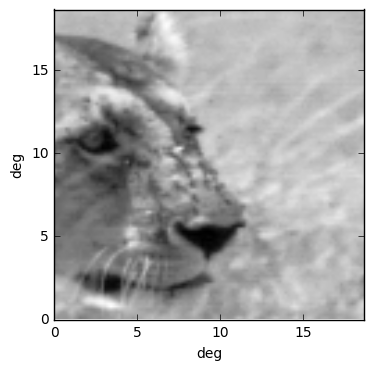

In [202]:
#show a sample image
def getsim(idx):
    sampleim = m[idx,:,:]
    return(sampleim)
    
#plt.imshow(sampleim,cmap='gray') #doesn't look quite as good.
#fig = plt.imshow(getsim(lion),cmap='Greys_r') #this map looks a bit better.

fig, ax = plt.subplots()
ax.imshow(getsim(lion), cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

In [11]:
## helper functions for animation

##embed animation as html

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML


#function we can call to animate with HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

#vanilla animation function
def animate(i):
    im.set_array(clip[i,:,:])
    return im,

In [12]:
##play the moive
samplevid = zebra
vidlen = 500

clip = m[samplevid:samplevid+vidlen,:,:]
cliplen = len(clip[:,1,1])

if(1):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
display_animation(anim)

In [13]:
# calculate difference (Dong & Atick 1995a, Figure 1)
def cdiff(fstart, dtms):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    diffim : numpy matrix with pixel values for dif between frames.
    
    """

    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1, fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))
    #time separation in frames
    df = ms2fr(dtms, fps)
    diff = abs(m[fstart,:,:].astype(int) - m[fstart+df,:,:].astype(int))
    return(diff)

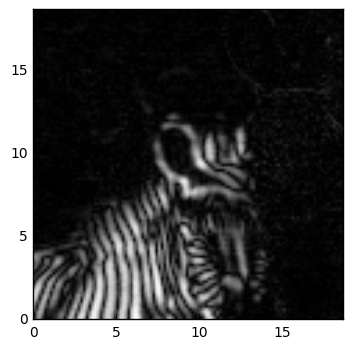

In [14]:
diffim = cdiff(zebra, 40)
plt.imshow(diffim,cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

## Cross Correlation

In [15]:
#average over all pixles
# calculate cross correlation (Dong & Atick 1995a)

##time separation in miliseconds at 25 fps min separation is 40ms.
dtms = 100
#time separation in frames
df = int(dtms * fps  /1000)
j = lion
onecc = np.corrcoef(vm[j,:], vm[j+df,:])
print(onecc)

[[ 1.          0.94216665]
 [ 0.94216665  1.        ]]


## Spatial Fourier Transform of One Raw Image

In [243]:
# from https://code.google.com/archive/p/agpy/downloads
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=complex)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    radial_prof = radial_prof[:int(np.floor(framew/2))-1]

    return radial_prof

In [252]:
def spatialft(image):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    ft2d = np.fft.fftshift(np.fft.fft2(image))
    
    #average over all orientations
    ft1d = azimuthalAverage(ft2d)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return(image, ft2d, ft1d, freq1d)

In [253]:
image, ft2d, ft1d, freq1d = spatialft(getsim(zebra))

<class 'numpy.complex128'>


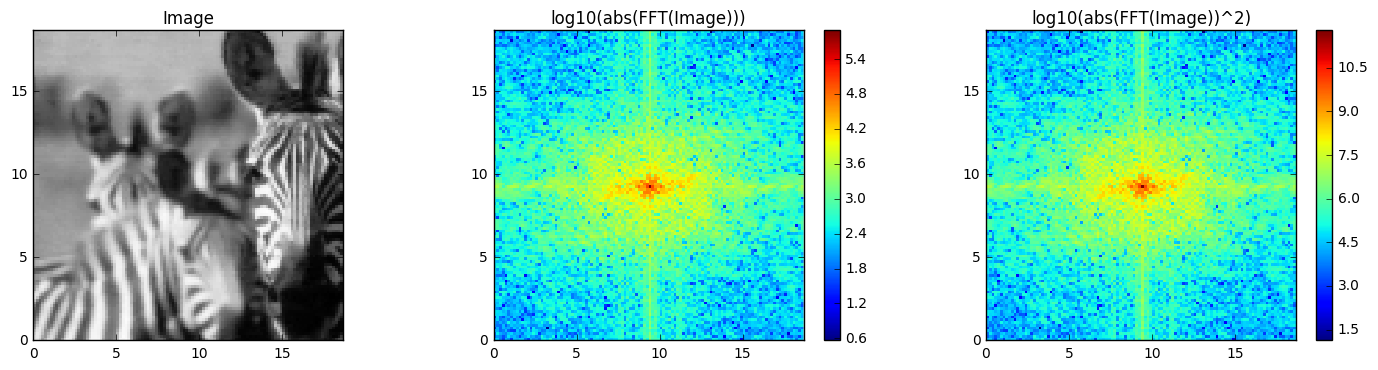

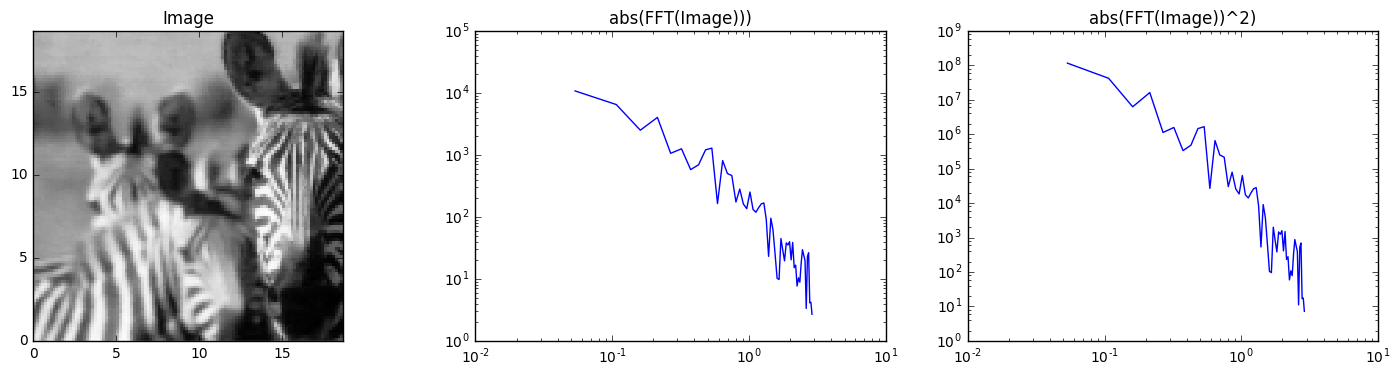

In [208]:
##plotting
#2d power spectra
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

plt.subplot(1,3,2,title='log10(abs(FFT(Image)))')
#plt.imshow(amp2D)
plt.imshow(np.log10(np.abs(ft2d)), interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

plt.subplot(1,3,3,title='log10(abs(FFT(Image))^2)')
#plt.imshow(psf2D)
plt.imshow(np.log10(np.abs(ft2d)**2), interpolation='none',extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')
plt.colorbar()

##azimuthal average
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='Image')
plt.imshow(image, cmap='Greys_r', interpolation='none', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

fig = plt.subplot(1,3,2,title='abs(FFT(Image)))')
plt.loglog(freq1d, np.abs(ft1d))

fig = plt.subplot(1,3,3,title='abs(FFT(Image))^2)')
plt.loglog(freq1d, np.abs(ft1d)**2)

plt.show()

## Average Spatial Fourier Transform over Many Images

In [209]:
def avgspatialft(movie):

    #take fourier transform over each fame
    fttimecube = np.fft.fft2(movie)
    
    #average over frames
    ftframemean = np.fft.fftshift(fttimecube.mean(axis=0))

    ##average over all orientations
    ft1dframemean = azimuthalAverage(ftframemean)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return ftframemean, ft1dframemean, freq1d

In [212]:
ftframemean, ft1dframemean, freq1d = avgspatialft(m)

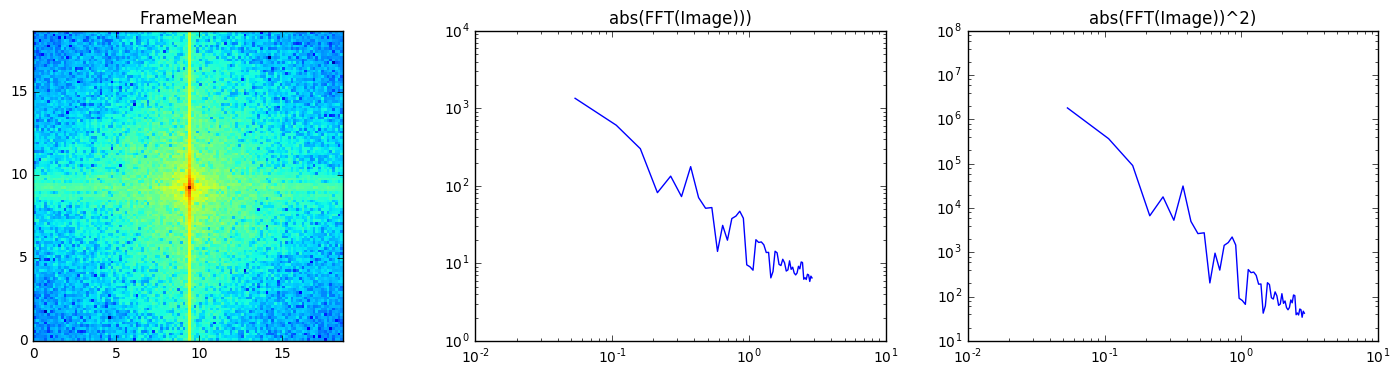

In [213]:
##plotting

##azimuthal average
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1,title='FrameMean')
plt.imshow(np.log10(np.abs(ftframemean)), interpolation='none', extent=[0,framewdeg,0,framehdeg])
ax.set_xlabel('deg')
ax.set_ylabel('deg')

fig = plt.subplot(1,3,2,title='abs(FFT(Image)))')
plt.loglog(freq1d, np.abs(ft1dframemean))

fig = plt.subplot(1,3,3,title='abs(FFT(Image))^2)')
plt.loglog(freq1d, np.abs(ft1dframemean)**2)

plt.show()

## Pairwise Probability Distribution (Temporal)

In [214]:
# calculate ppd (Dong & Atick 1995a, Figure 2)
def gettemporalppd(fstart, fend, dtms):
    """
    calculated pairwise probability distribution

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    ppd : numpy matrix with pairwise probability distribution.
    
    """
    
    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1,fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))    
    #time separation in frames
    df = ms2fr(dtms, fps)
    
    #levels of light intensity
    lil = 256
    #initialize blank matrix to tally pairs
    ppd = np.zeros((lil,lil))
    #go through all pixels and tally up light intensity pairs
    
    for f in range(fstart,fend-df):
        s1 = vm[f,:]
        s2 = vm[f+df,:]
        for i in range(np.size(s1)):
            ppd[s1[i],s2[i]]+=1
    return(ppd)

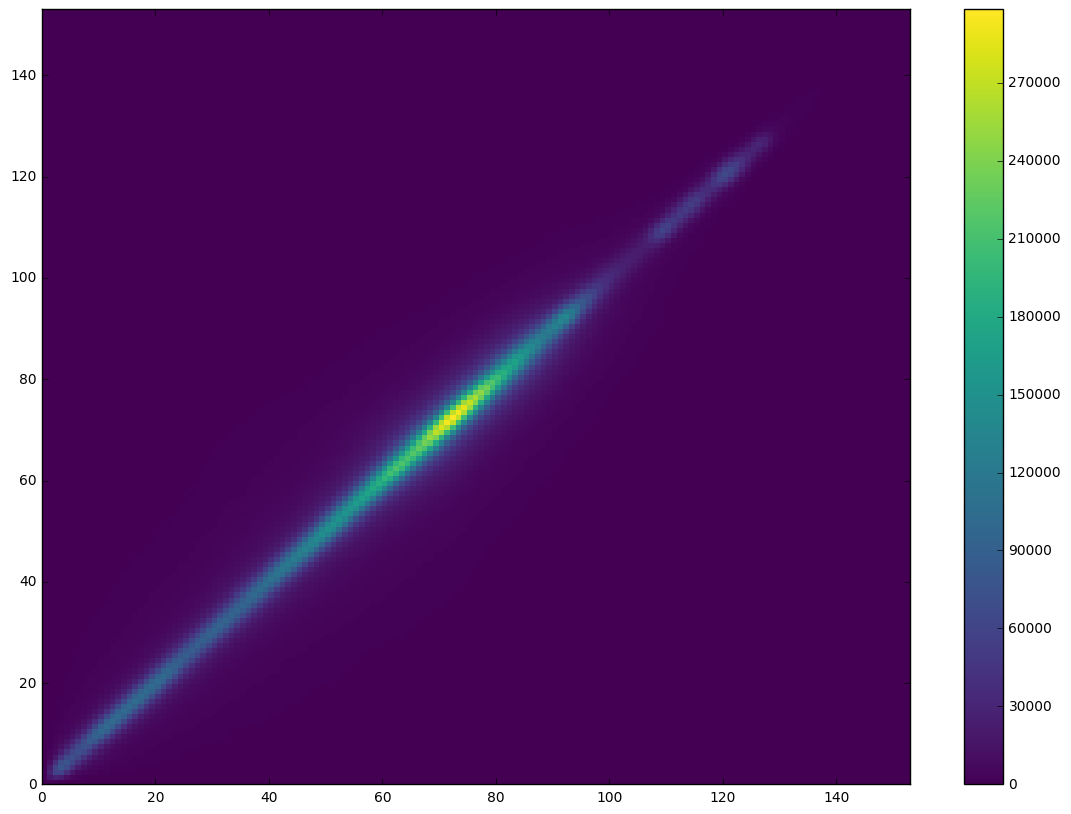

In [215]:
dt = 40*2
myppd = gettemporalppd(0,len(vm),dt)

plt.figure(figsize=(14,10))
plt.pcolormesh(myppd,cmap='viridis')
plt.xlim(0,153)
plt.ylim(0,153)
plt.colorbar()

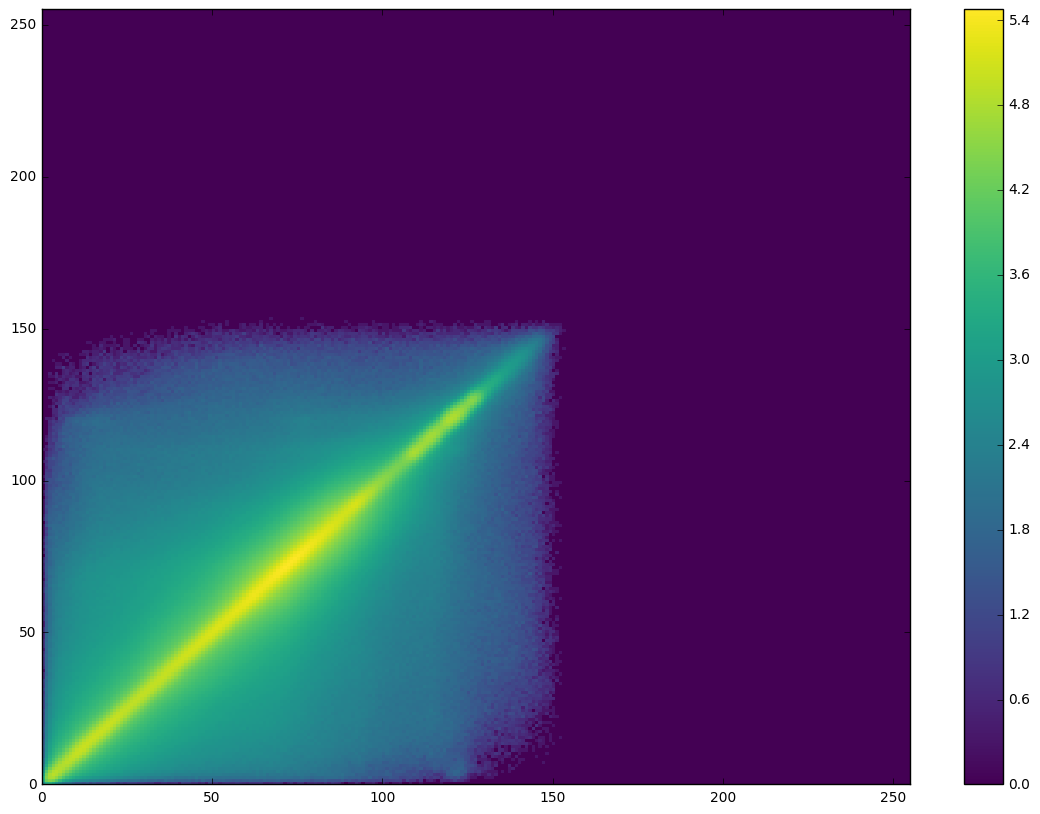

In [216]:
mylppd = np.log10(myppd+1)
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='viridis')
plt.xlim(0,255)
plt.ylim(0,255)
plt.colorbar()

## Where are the cuts?

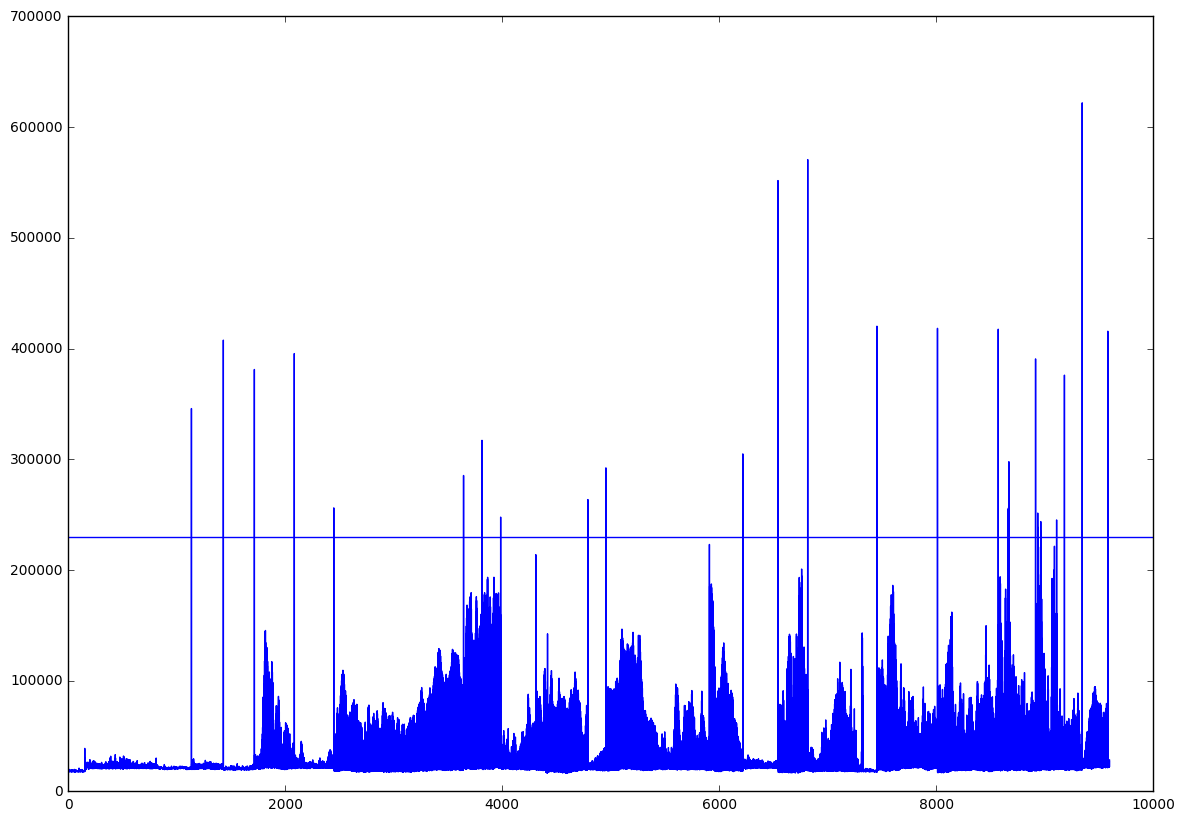

In [217]:
fchange = np.zeros(len(m)-1)
for f in range(len(m)-1):
    fchange[f] = np.sum(cdiff(f, 40))

plt.figure(figsize=(14,10))
plt.plot(fchange)
        
plt.axhline(230000)

## Ignore cuts for now and take 3DFFT

In [184]:
stft = np.fft.rfftn(mm,axes=[0]) #time fourier transform
stfq = np.fft.fftfreq(mm[:,0,0].size, d=1./fps)

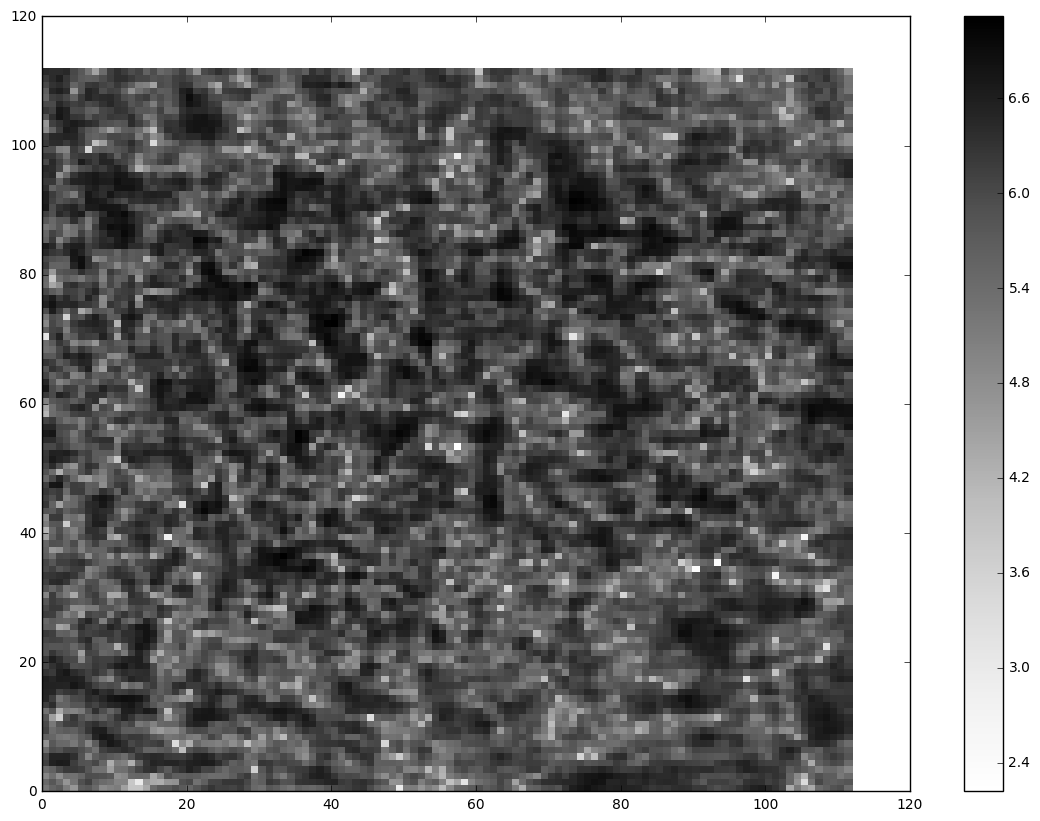

In [67]:
mylppd = np.log10(stps[int(zebra/2+3),:,:]+1)
plt.figure(figsize=(14,10))
plt.pcolormesh(mylppd,cmap='Greys')
plt.colorbar()

In [68]:
##play the moive
samplevid = 0
vidlen = 1000

#if we don't take the log you can't see much.
clip = np.log10(stps[samplevid:samplevid+vidlen,:,:])
cliplen = len(clip[:,1,1])

if(1):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:], cmap='Greys_r')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
display_animation(anim)
anim.save('temporalfftlog.mp4', fps=fps,bitrate=-1)

## Average over Many Clips & Make the Football

In [400]:
def make_tdft(movie,fchunk):
    if(fchunk%2 != 0):
        raise Exception('Error, fchunk must be an even number!')

    nchunks = int(np.floor(len(movie[:,0,0])/fchunk))
    
    #take fourier transform over each fame
    fttimecube = np.fft.fft2(movie)
    
    chunklist = []
    
    #break into chunks
    for chunk in range(nchunks):
        chunkmov = fttimecube[chunk*fchunk:(chunk+1)*fchunk]
        #space FT for each chunk
        chunklist.append(np.fft.fftn(chunkmov,axes=[0]))
    chunklist=np.array(chunklist)
    #mean of chunks
    mftchunk = np.mean(chunklist,axis=0)
    
    #do fft shifts to make football
    mftchunk = np.fft.fftshift(mftchunk)
    
    #array to hold azmaverage
    azmchunk = np.zeros([fchunk,int(np.floor(framew/2))-1], dtype=complex)
    
    ##spin to get mean
    for f in range(fchunk):
        azmchunk[f] = azimuthalAverage(np.abs(mftchunk[f]))
        
    azmchunk = (azmchunk[int(fchunk/2):] + azmchunk[int(fchunk/2):0:-1]) / 2
      
    #get the sampling rate for azmavgd
    freqspace1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    #get the sampling rates
    freqspacefull = np.fft.fftshift(np.fft.fftfreq(framew, d=1./ppd))
    freqtime = np.fft.fftshift(np.fft.fftfreq(fchunk, d=1./fps))[int(fchunk/2):]
    
    return mftchunk, azmchunk, freqspace1d, freqspacefull, freqtime

In [418]:
##call function to take mean FT in space.
football, azmchunk, fqspace1d, fqspacefull, fqtime = make_tdft(m, 100)

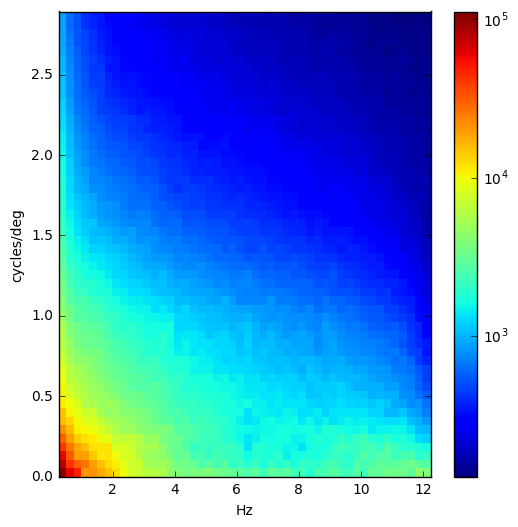

In [514]:
plt.figure(figsize=(6,6))
plt.pcolormesh(fqtime[1:], fqspace1d, np.abs(azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(azmchunk.T[1:,1:]).min(), vmax=np.abs(azmchunk.T[:,1:]).max()))

plt.xlim(fqtime[1],np.max(fqtime))
plt.ylim(0,np.max(fqspace1d[1:]))

plt.xlabel('Hz')
plt.ylabel('cycles/deg')


plt.colorbar()

(100, 112, 112)

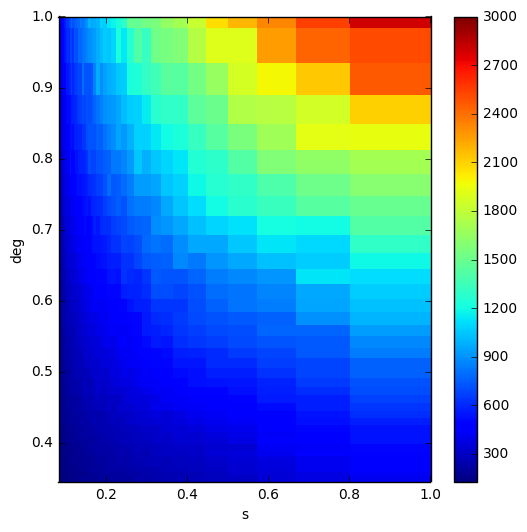

In [515]:
plt.figure(figsize=(6,6))
plt.pcolormesh(1/(fqtime[1:]),
               1/(fqspace1d[1:]),
               np.abs(azmchunk[1:,1:].T), vmax=3000)
#                norm=mpl.colors.LogNorm(vmin=90,
#                                         vmax=11000))

plt.xlim(np.min(1/(fqtime[1:])),1)
plt.ylim(np.min(1/(fqspace1d[1:])),1)
plt.colorbar()
plt.xlabel('s')
plt.ylabel('deg')
np.shape(football)

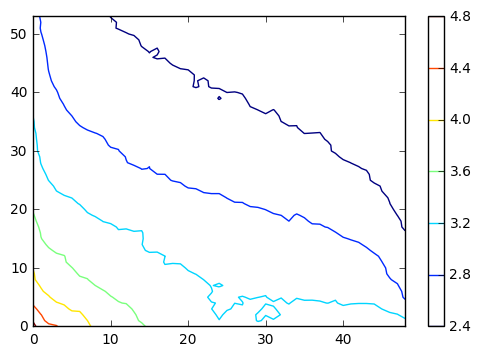

In [534]:
## kelly plot
plt.figure()
plt.contour(np.log10(np.abs(azmchunk[1:,1:]).T),cmap='jet') #remove dc component (0hz) from time and 0 cycles/deg from space
plt.colorbar()

## Sample from Spatial Frequency Spectrum

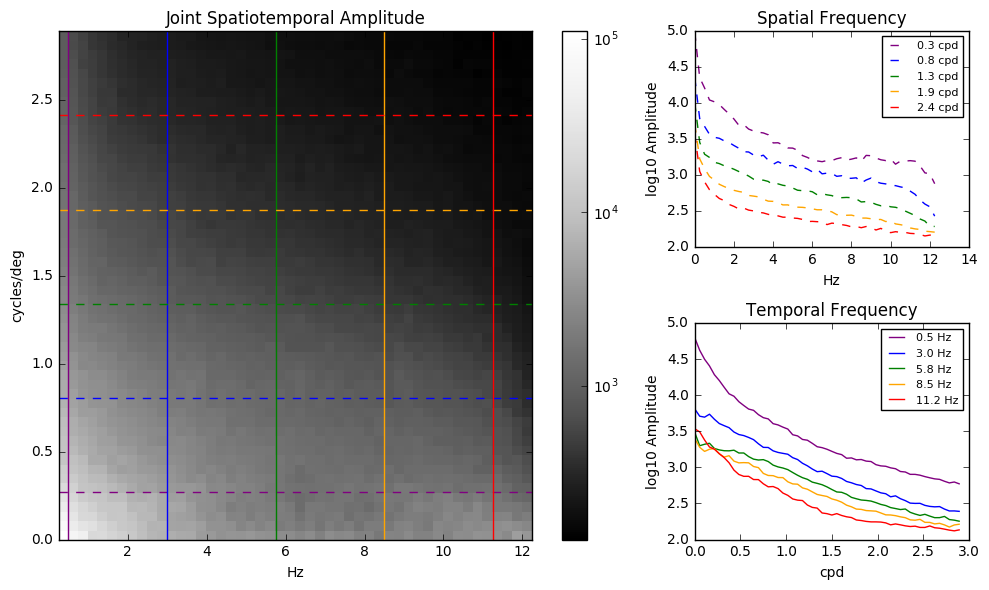

In [580]:
import matplotlib.gridspec as gsp

nsamples = 5

spacemin = 5
spacemax = 45
timemin = 2
timemax = 45

#colors for lines
spacesamplefqs = np.linspace(spacemin,spacemax,nsamples).astype(int)
timesamplefqs = np.linspace(timemin,timemax,nsamples).astype(int)

spacecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]
timecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, np.abs(azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(azmchunk.T[1:,1:]).min(), 
                                      vmax=np.abs(azmchunk.T[:,1:]).max()),
                  cmap='Greys_r')
axes_hm.set_xlim(fqtime[1],np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Amplitude')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.plot(fqtime, np.log10(np.abs(azmchunk.T))[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.set_title('Spatial Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('log10 Amplitude') 
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.plot(fqspace1d, np.log10(np.abs(azmchunk.T))[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.set_title('Temporal Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('log10 Amplitude') 
axes_space.legend(fontsize=8)


plt.tight_layout()

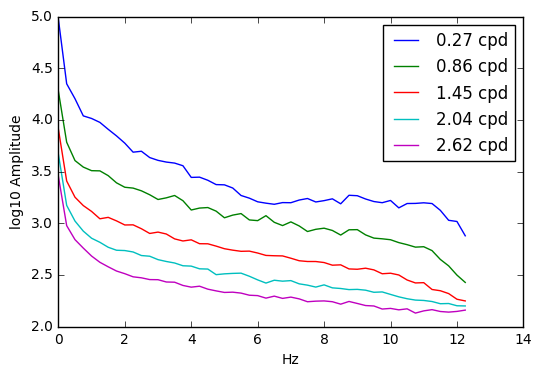

In [551]:
for sf in spacesamplefqs:
    plt.plot(fqtime, np.log10(np.abs(azmchunk.T))[sf,:],label='{0:0.2f} cpd'.format(fqspace1d[sf]))
plt.xlabel('Hz')
plt.ylabel('log10 Amplitude')
    
plt.legend()

## Sample from Temporal Frequency Spectrum

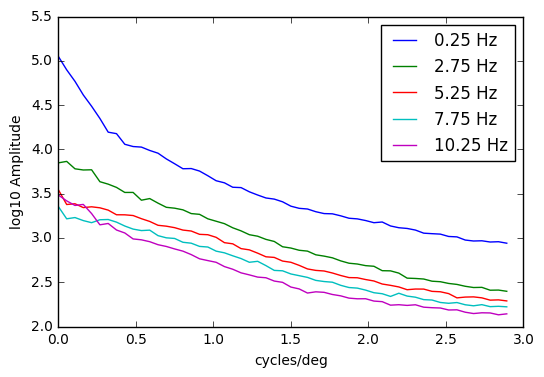

In [484]:
for sf in timesamplefqs:
    plt.plot(fqspace1d, np.log10(np.abs(azmchunk.T))[:,sf],
             label='{0:0.2f} Hz'.format(fqtime[sf]))
plt.xlabel('cycles/deg')
plt.ylabel('log10 Amplitude')  
plt.legend()


## Meeting with Bruno - Notes to update:  

### Action Items

Change to chunks so the Rayleigh frequency is on the order of something sensible. Right now it's 1 cycle per the entire movie. Averaging over the chunks will also make the data better.

.64 cycles/images max (nuyquist)
0.5 cycles per pixel

Add powers then take sqrt

Discreet fourier transform - Need tapering function on outside of image (use raised cosine)  Do this in time also

Urs' duck movie (ask dyaln for this) might be a better movie than the VH movie.  

For motion sharpening:
Need to figure out the encoding. Also ask Dylan about ffmpeg, this might be a good way to do it.  

Adjust for a DC gain of 1 by ensuring filter sums to 1.  

Coinsider boosting low pass frames

Or blending in high pass filter over time (so we don't just have hole - this may stop the flickering. 